# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [58]:
from pathlib import Path
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [59]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)
idx = pd.IndexSlice

## Alphalens Analysis

In [60]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [235]:
def get_trade_prices(tickers):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, '2012':'2017'], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [236]:
predictions = pd.read_hdf('predictions.h5', 'predictions').iloc[:, :4].mean(1).to_frame('prediction')

In [238]:
factor = (predictions
          .unstack('symbol')
          .asfreq('D')
          .dropna(how='all')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('symbol').unique()

In [239]:
factor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 513427 entries, (2013-12-27 00:00:00+00:00, A) to (2017-12-28 00:00:00+00:00, ZTS)
Data columns (total 1 columns):
prediction    513427 non-null float64
dtypes: float64(1)
memory usage: 5.9+ MB


In [240]:
trade_prices = get_trade_prices(tickers)

In [241]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2012-01-03 to 2017-12-29
Columns: 572 entries, A to ZTS
dtypes: float64(572)
memory usage: 6.6 MB


In [244]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21)).sort_index()
factor_data.info()

Dropped 42.4% entries from factor data: 2.5% in forward returns computation and 39.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 50.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 295541 entries, (2013-12-27 00:00:00+00:00, A) to (2017-11-28 00:00:00+00:00, ZTS)
Data columns (total 6 columns):
1D                 295541 non-null float64
5D                 295541 non-null float64
10D                295541 non-null float64
21D                295541 non-null float64
factor             295541 non-null float64
factor_quantile    295541 non-null float64
dtypes: float64(6)
memory usage: 14.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.002032,0.001599,0.000907,0.000565,59317,20.070650
2.0,-0.000123,0.001601,0.000921,0.000564,59035,19.975232
3.0,-0.000122,0.001602,0.000929,0.000565,58973,19.954253
4.0,-0.000121,0.001603,0.000946,0.000564,60064,20.323407
5.0,-0.000119,0.175345,0.000956,0.001507,58152,19.676458


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.338,0.229,0.193,0.167
beta,0.198,0.096,-0.270,-0.386
Mean Period Wise Return Top Quantile (bps),2.904,7.002,13.422,9.857
Mean Period Wise Return Bottom Quantile (bps),-2.319,-2.807,-2.464,-2.034
Mean Period Wise Spread (bps),5.224,7.908,9.672,6.504


Information Analysis


,1D,5D,10D,21D
IC Mean,0.002,0.015,0.016,0.016
IC Std.,0.163,0.164,0.165,0.149
Risk-Adjusted IC,0.011,0.094,0.096,0.111
t-stat(IC),0.257,2.279,2.335,2.684
p-value(IC),0.797,0.023,0.020,0.007
IC Skew,-0.900,-0.862,-0.783,-1.229
IC Kurtosis,7.041,7.010,6.719,9.911


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.612,0.253,0.701,0.499
Quantile 2 Mean Turnover,0.738,0.467,0.770,0.685
Quantile 3 Mean Turnover,0.759,0.512,0.781,0.717
Quantile 4 Mean Turnover,0.736,0.456,0.766,0.677
Quantile 5 Mean Turnover,0.582,0.241,0.697,0.468


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.864,0.569,0.389,0.195


<Figure size 432x288 with 0 Axes>

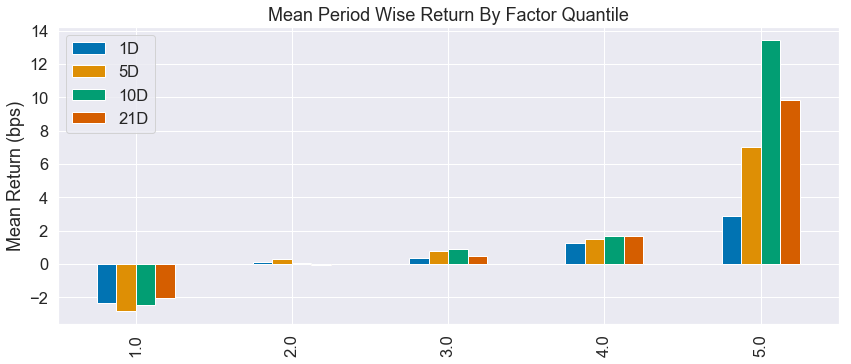

In [245]:
create_summary_tear_sheet(factor_data);

### Load zipline extensions

Only need this in notebook to find bundle.

In [318]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [319]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [341]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 10

## Load Data

### Quandl Wiki Bundel

In [342]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [343]:
def load_predictions(bundle):
    predictions = pd.read_hdf('predictions.h5', 'predictions/1/03').loc[:, [8,9,5]].mean(1).to_frame('prediction')
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [344]:
predictions, assets = load_predictions(bundle_data)

In [345]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2013-12-27 to 2017-12-28
Columns: 572 entries, 0 to 3197
dtypes: float64(572)
memory usage: 4.4 MB


### Define Custom Dataset

In [346]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [347]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [348]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [349]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS),
        'shorts': signals.bottom(N_SHORTS)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [350]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.longs = context.shorts = None
    set_slippage(slippage.FixedSlippage(spread=0.00))
#     set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [351]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    longs = pipeline_output('signals').longs.astype(int)
    shorts = pipeline_output('signals').shorts.astype(int)
    holdings = context.portfolio.positions.keys()
    
    if longs.sum() > MIN_POSITIONS and shorts.sum() > MIN_POSITIONS:
        context.longs = longs[longs!=0].index
        context.shorts = shorts[shorts!=0].index
        context.divest = holdings - set(context.longs) - set(context.shorts)
    else:
        context.longs = context.shorts = pd.Index([])
        context.divest = set(holdings)

## Define Rebalancing Logic

In [352]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
          
    for stock in context.divest:
        order_target(stock, target=0)
    
#     log.warning('{} {:,.0f}'.format(len(context.portfolio.positions), context.portfolio.portfolio_value))
    if not (context.longs.empty and context.shorts.empty):
        for stock in context.shorts:
            order_target_percent(stock, -1 / len(context.shorts) / 2)
        for stock in context.longs:
            order_target_percent(stock, 1 / len(context.longs))

## Record Data Points

In [353]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [354]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [355]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2013-12-27
End:   2017-12-28


In [356]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-03-22 00:07:07.374270]: WARNING: ensure_benchmark_data: Still don't have expected benchmark data for 'SPY' from 1989-12-29 00:00:00+00:00 to 2020-03-20 00:00:00+00:00 after redownload!
[2020-03-22 00:07:07.996757]: WARNING: ensure_treasury_data: Still don't have expected treasury data for 'SPY' from 1990-01-02 00:00:00+00:00 to 2020-03-20 00:00:00+00:00 after redownload!
[2020-03-22 00:07:20.175279]: WARNING: _can_order_asset: Cannot place order for RVBD, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-04-25 00:00:00+00:00.
[2020-03-22 00:07:22.249255]: WARNING: _can_order_asset: Cannot place order for WLT, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-07-08 00:00:00+00:00.
[2020-03-22 00:07:22.601543]: WARNING: _can_order_asset: Cannot place order for ANR, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-07-17 00:00:00+00:00.
[2020-03-22 00:07:30.700880]: WARNING: _

Duration: 44.40s


## PyFolio Analysis

In [357]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [358]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

In [365]:
LIVE_DATE = '2018-01-01'

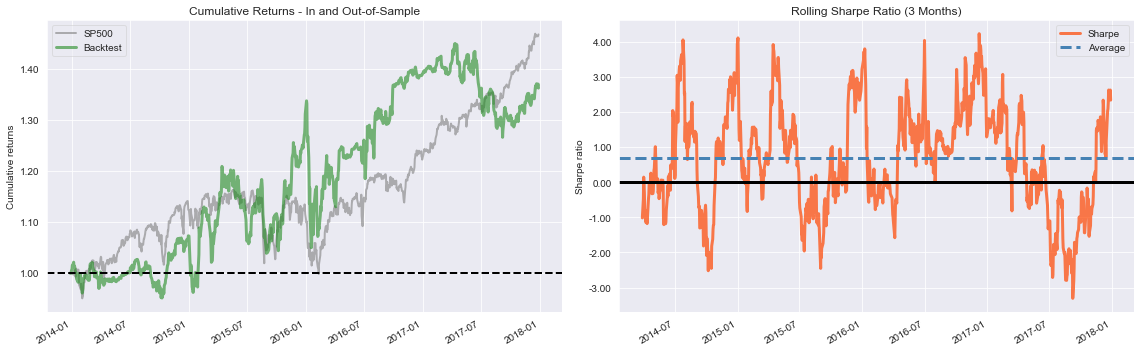

In [366]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig('figures/pyfolio_out_of_sample', dpi=300);

### Tear Sheets

Start date,2014-01-01
End date,2018-01-01
Total months,49
,Backtest
Annual return,7.6%
Cumulative returns,35.6%
Annual volatility,17.3%
Sharpe ratio,0.53
Calmar ratio,0.36
Stability,0.85
Max drawdown,-21.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.47,2016-01-04,2016-01-19,2016-09-28,193
1,14.06,2015-04-15,2015-09-01,2015-11-19,157
2,12.66,2017-04-12,2017-09-07,NaT,NaN
3,10.32,2015-01-01,2015-01-15,2015-02-03,24
4,9.58,2015-02-18,2015-03-13,2015-04-06,34


Stress Events,mean,min,max
Apr14,0.01%,-0.91%,1.80%
Oct14,0.24%,-1.84%,1.54%
Fall2015,-0.16%,-2.74%,2.14%
New Normal,0.04%,-5.99%,5.05%


Top 10 long positions of all time,max
sid,
DNR,6.08%
WLT,6.01%
WLL,5.68%
ACI,5.64%
SUNE,5.51%
WMB,5.22%
UTHR,5.11%
CHK,4.99%
RH,4.95%


Top 10 short positions of all time,max
sid,
GMCR,-3.45%
ACI,-3.13%
SUNE,-3.10%
CBI,-2.81%
RAD,-2.63%
FCX,-2.60%
AKAM,-2.55%
CLF,-2.54%
DNR,-2.53%


Top 10 positions of all time,max
sid,
DNR,6.08%
WLT,6.01%
WLL,5.68%
ACI,5.64%
SUNE,5.51%
WMB,5.22%
UTHR,5.11%
CHK,4.99%
RH,4.95%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,25419.00,13767.00,11652.00
Percent profitable,0.43,0.35,0.53
Winning round_trips,10907.00,4766.00,6141.00
Losing round_trips,10655.00,5206.00,5449.00
Even round_trips,3857.00,3795.00,62.00


PnL stats,All trades,Short trades,Long trades
Total profit,$14770.08,$4733.65,$10036.44
Gross profit,$649862.39,$226433.80,$423428.58
Gross loss,$-635092.30,$-221700.15,$-413392.15
Profit factor,$1.02,$1.02,$1.02
Avg. trade net profit,$0.58,$0.34,$0.86
Avg. winning trade,$59.58,$47.51,$68.95
Avg. losing trade,$-59.61,$-42.59,$-75.87
Ratio Avg. Win:Avg. Loss,$1.00,$1.12,$0.91
Largest winning trade,$10538.22,$10538.22,$3426.11
Largest losing trade,$-6482.23,$-6482.23,$-4536.44


Duration stats,All trades,Short trades,Long trades
Avg duration,5 days 11:05:08.746646,5 days 07:53:23.836493,5 days 14:51:41.957947
Median duration,2 days 00:00:00,2 days 00:00:00,3 days 00:00:00
Longest duration,419 days 01:00:00,319 days 00:00:00,419 days 01:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,0.00%,0.00%
Avg returns winning,0.05%,0.04%,0.06%
Avg returns losing,-0.05%,-0.04%,-0.06%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.02%,0.02%,0.02%
Median returns losing,-0.01%,-0.01%,-0.02%
Largest winning trade,8.72%,8.72%,2.86%
Largest losing trade,-5.70%,-5.70%,-3.97%


Symbol stats,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACE,ACI,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEO,AEP,AES,AET,AFL,AGCO,AGN,AGNC,AIG,AKAM,AKS,ALK,ALL,ALTR,ALXN,AMAT,AMD,AMG,AMGN,AMP,AMT,AMTD,AMZN,ANF,ANR,ANTM,AON,APA,APC,APD,APH,APOL,ARNC,ARO,ASH,ATI,ATVI,AVB,AVGO,AVP,AXP,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BCR,BDX,BEN,BG,BHI,BIDU,BIIB,BK,BLK,BLL,BMRN,BMY,BP,BRCM,BRK_B,BSX,BWA,BXP,C,CA,CAG,CAH,CAM,CAR,CAT,CB,CBG,CBI,CCE,CCI,CCL,CE,CELG,CERN,CF,CHK,CHKP,CHRW,CHTR,CI,CIEN,CIT,CL,CLF,CLR,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNC,CNP,CNX,COF,COG,COH,COL,COP,COST,COV,CPB,CPN,CREE,CRM,CSCO,CSX,CTL,CTSH,CTXS,CVS,CVX,CXO,D,DAL,DATA,DD,DE,DECK,DF,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISH,DKS,DLPH,DLR,DLTR,DNR,DO,DOV,DOW,DPS,DRI,DTE,DTV,DUK,DVA,DVN,EA,EBAY,ECL,ED,EIX,EL,EMC,EMN,EMR,ENDP,EOG,EQIX,EQR,EQT,ES,ESI,ESRX,ESS,ESV,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,F,FANG,FAST,FB,FCX,FDO,FDX,FE,FFIV,FIS,FISV,FITB,FL,FLR,FLS,FLT,FOSL,FOX,FOXA,FRX,FSLR,FST,FTI,GD,GE,GILD,GIS,GLW,GM,GMCR,GME,GNW,GOLD,GOOGL,GPS,GRPN,GS,GT,GWW,HAL,HAS,HBAN,HBI,HCA,HCN,HCP,HD,HES,HFC,HLF,HOG,HOLX,HON,HOT,HP,HPQ,HRB,HSH,HST,HSY,HTZ,HUM,IBM,ICE,IGT,ILMN,INCY,INTC,INTU,IP,IPG,IR,ISRG,ITW,IVZ,JBHT,JBL,JBLU,JCI,JCP,JDSU,JEC,JNJ,JNPR,JOY,JPM,JWN,K,KBH,KEY,KIM,KLAC,KMB,KMI,KMX,KO,KORS,KR,KSS,KSU,L,LB,LBTYA,LEA,LEN,LH,LINTA,LLL,LLTC,LLY,LM,LMT,LNC,LNG,LNKD,LO,LOW,LRCX,LUV,LVLT,LVS,LYB,M,MA,MAR,MAS,MAT,MCD,MCHP,MCK,MCO,MCP,MDLZ,MDT,MET,MGM,MHFI,MHK,MJN,MLM,MMC,MMM,MNK,MNST,MO,MON,MOS,MPC,MRK,MRO,MRVL,MS,MSFT,MSI,MTB,MU,MUR,MXIM,MYL,NBL,NBR,NE,NEE,NEM,NFLX,NFX,NKE,NLSN,NLY,NOC,NOV,NOW,NRG,NSC,NTAP,NTRS,NU,NUAN,NUE,NVDA,NWL,O,OAS,OKE,OMC,ONNN,ORCL,ORLY,OXY,P,PANW,PAYX,PCAR,PCG,PCLN,PCP,PEG,PEP,PETM,PFE,PFG,PG,PGR,PH,PHM,PII,PLD,PM,PNC,PNR,PNRA,PPG,PPL,PRGO,PRU,PSA,PSX,PTEN,PVH,PWR,PX,PXD,QCOM,QEP,RAD,RAI,RAX,RCL,RDC,REGN,RF,RH,RHT,RIG,RL,ROK,ROP,ROST,RRC,RSG,RTN,RVBD,S,SBAC,SBUX,SCCO,SCHW,SE,SEE,SHW,SIG,SIRI,SJM,SLB,SLG,SLM,SM,SNDK,SO,SPG,SPLK,SPLS,SRE,STI,STJ,STT,STX,STZ,SUNE,SWK,SWKS,SWN,SWY,SYK,SYMC,SYY,T,TAP,TDC,TDG,TEL,TEX,TGT,THC,TIBX,TIF,TJX,TMO,TMUS,TOL,TRIP,TROW,TRUE,TRV,TRW,TSCO,TSLA,TSN,TSO,TWC,TWTR,TWX,TXN,TXT,TYC,UAA,UAL,ULTA,UNH,UNM,UNP,UPL,UPS,URBN,URI,USB,UTHR,UTX,V,VAR,VFC,VIAB,VLO,VMC,VMW,VNO,VOD,VRSN,VRTX,VRX,VTR,VZ,WAG,WAT,WBA,WDAY,WDC,WEC,WFC,WFM,WHR,WLL,WLT,WM,WMB,WMT,WU,WY,WYN,WYNN,X,XEC,XEL,XL,XLNX,XOM,XRX,YELP,YHOO,YUM,ZBH,ZION,ZMH,ZTS
Avg returns all round_trips,-0.00%,0.00%,0.00%,-0.01%,0.00%,-0.00%,0.00%,0.01%,-0.05%,0.00%,0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,-0.00%,0.01%,0.00%,0.00%,0.02%,0.01%,0.00%,0.01%,0.03%,0.00%,0.01%,0.00%,-0.00%,0.01%,0.02%,-0.12%,0.03%,-0.00%,-0.00%,0.01%,-0.02%,-0.00%,-0.03%,-0.00%,-0.02%,-0.07%,0.04%,0.00%,0.01%,-0.01%,0.02%,0.01%,-0.01%,-0.01%,0.01%,0.01%,-0.04%,-0.02%,0.01%,-0.01%,0.02%,0.02%,0.00%,0.02%,0.01%,0.01%,-0.01%,-0.03%,-0.02%,0.05%,0.00%,-0.02%,0.01%,-0.01%,-0.02%,0.02%,-0.00%,0.01%,-0.00%,-0.01%,0.00%,0.05%,-0.01%,0.02%,0.01%,0.00%,-0.02%,0.02%,-0.01%,-0.00%,-0.03%,-0.03%,0.01%,-0.02%,0.03%,-0.01%,0.01%,-0.02%,0.02%,0.00%,-0.03%,0.00%,0.03%,-0.02%,0.00%,0.03%,-0.01%,-0.02%,-0.01%,-0.07%,-0.00%,0.00%,-0.02%,-0.01%,0.01%,-0.01%,0.01%,0.00%,-0.02%,-0.04%,0.01%,0.01%,-0.00%,0.01%,-0.01%,0.00%,0.02%,-0.01%,-0.01%,-0.03%,-0.01%,0.03%,0.00%,-0.02%,-0.00%,-0.01%,0.04%,0.06%,0.06%,0.06%,-0.00%,0.05%,-0.01%,-0.04%,0.01%,-0.01%,0.01%,0.01%,0.01%,0.02%,-0.01%,-0.01%,0.02%,-0.02%,0.00%,0.01%,0.03%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%,-0.02%,0.00%,0.02%,0.00%,-0.01%,-0.01%,0.00%,0.00%,-0.01%,0.03%,0.00%,-0.02%,-0.02%,-0.01%,-0.01%,-0.06%,0.00%,0.06%,-0.04%,-0.01%,-0.02%,-0.00%,-0.01%,-0.01%,0.04%,0.01%,-0.02%,0.03%,0.03%,0.04%,-0.00%,0.00%,0.02%,-0.01%,-0.01%,0.01%,-0.01%,0.03%,0.01%,0.01%,-0.00%,-0.01%,0.01%,-0.04%,-0.00%,-0.01%,0.00%,-0.15%,0.00%,0.08%,-0.01%,-0.00%,0.01%,0.02%,0.00%,-0.00%,0.00%,-0.01%,-0.06%,0.03%,0.01%,-0.00%,-0.01%,0.00%,-0.00%,-0.01%,0.02%,-0.02%,-0.01%,0.04%,0.02%,-0.03%,0.01%,0.01%,0.03%,0.03%,0.00%,0.05%,-0.01%,-0.00%,-0.01%,-0.04%,0.01%,-0.01%,0.00%,-0.02%,0.00%,-0.02%,-0.00%,-0.0

Profitability (PnL / PnL total) per name,
symbol,
CLF,34.91%
GNW,28.90%
UPL,25.89%
SUNE,24.78%
CHK,24.19%
HLF,22.46%
NBR,20.66%
AAL,16.77%
WYNN,15.12%


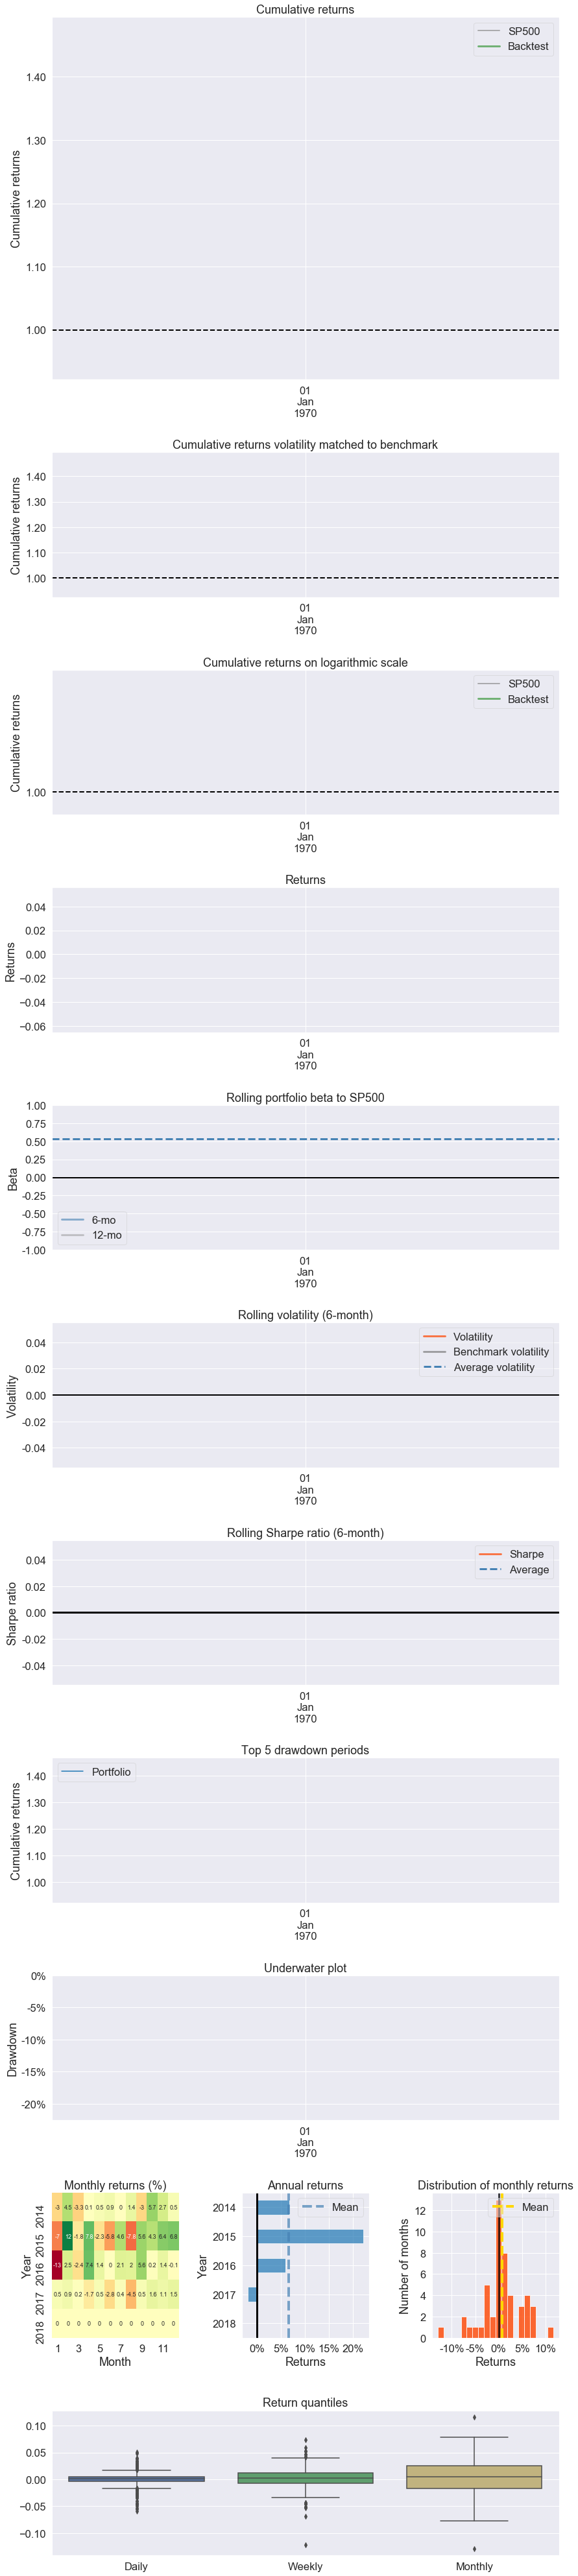

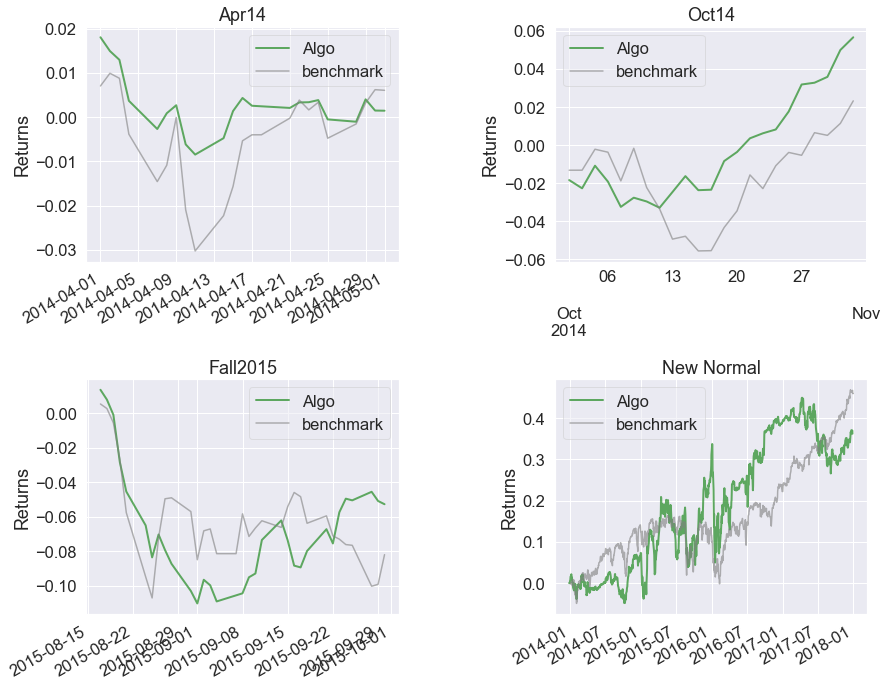

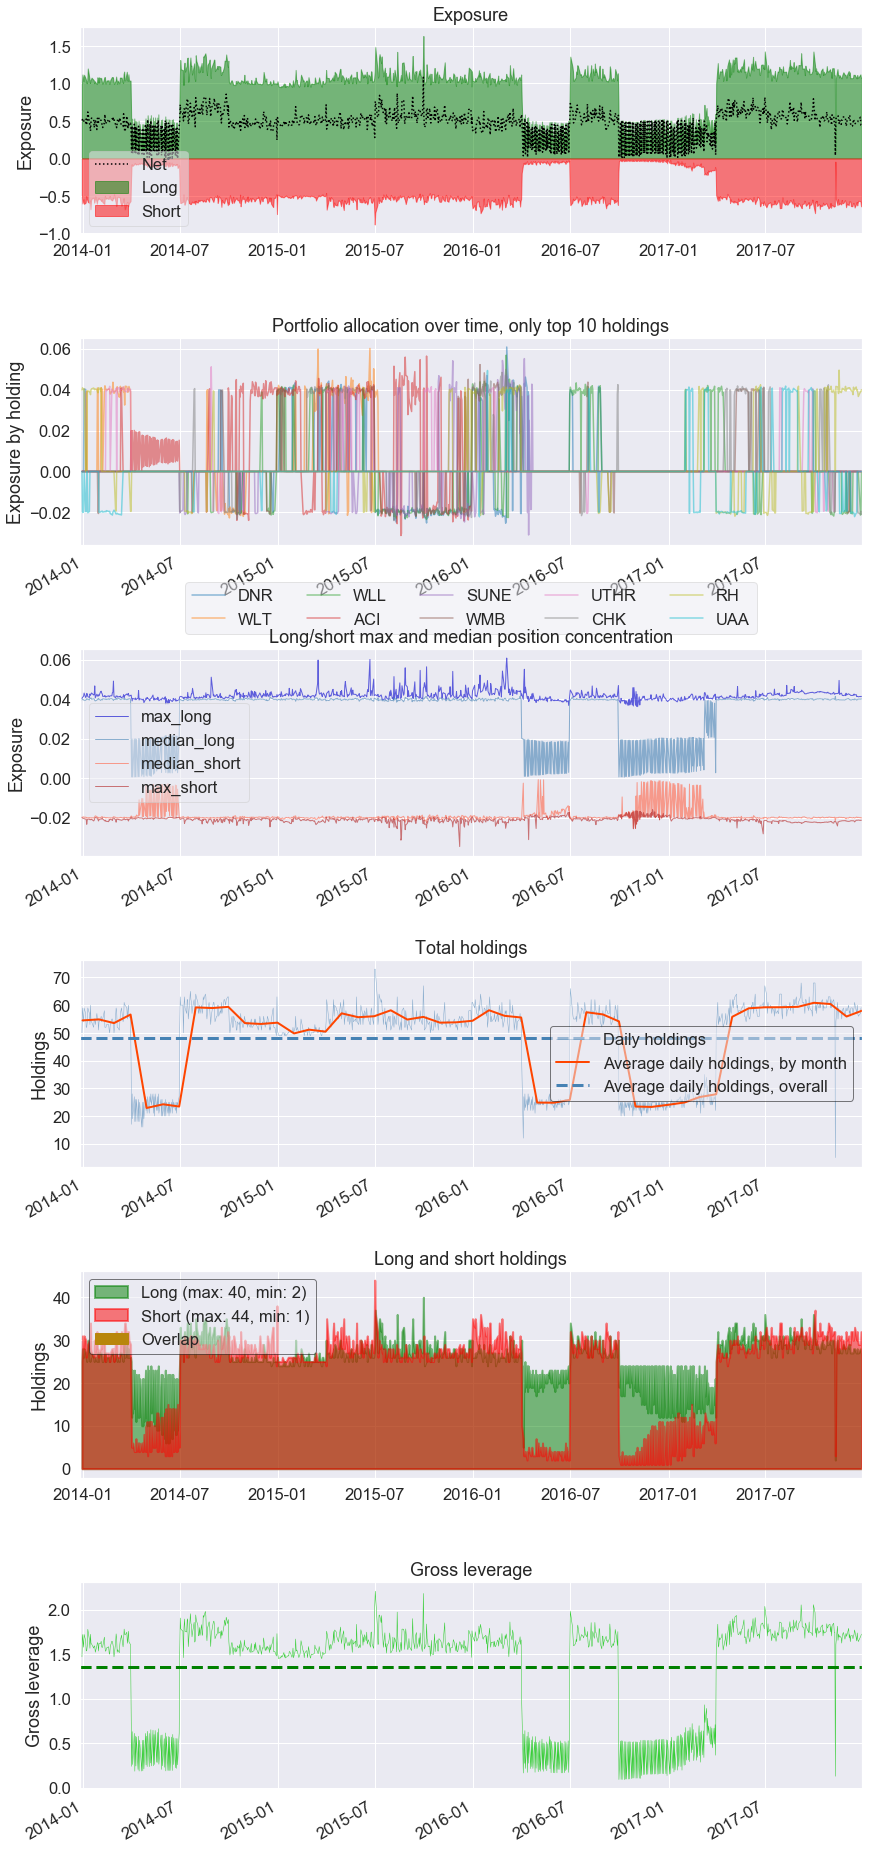

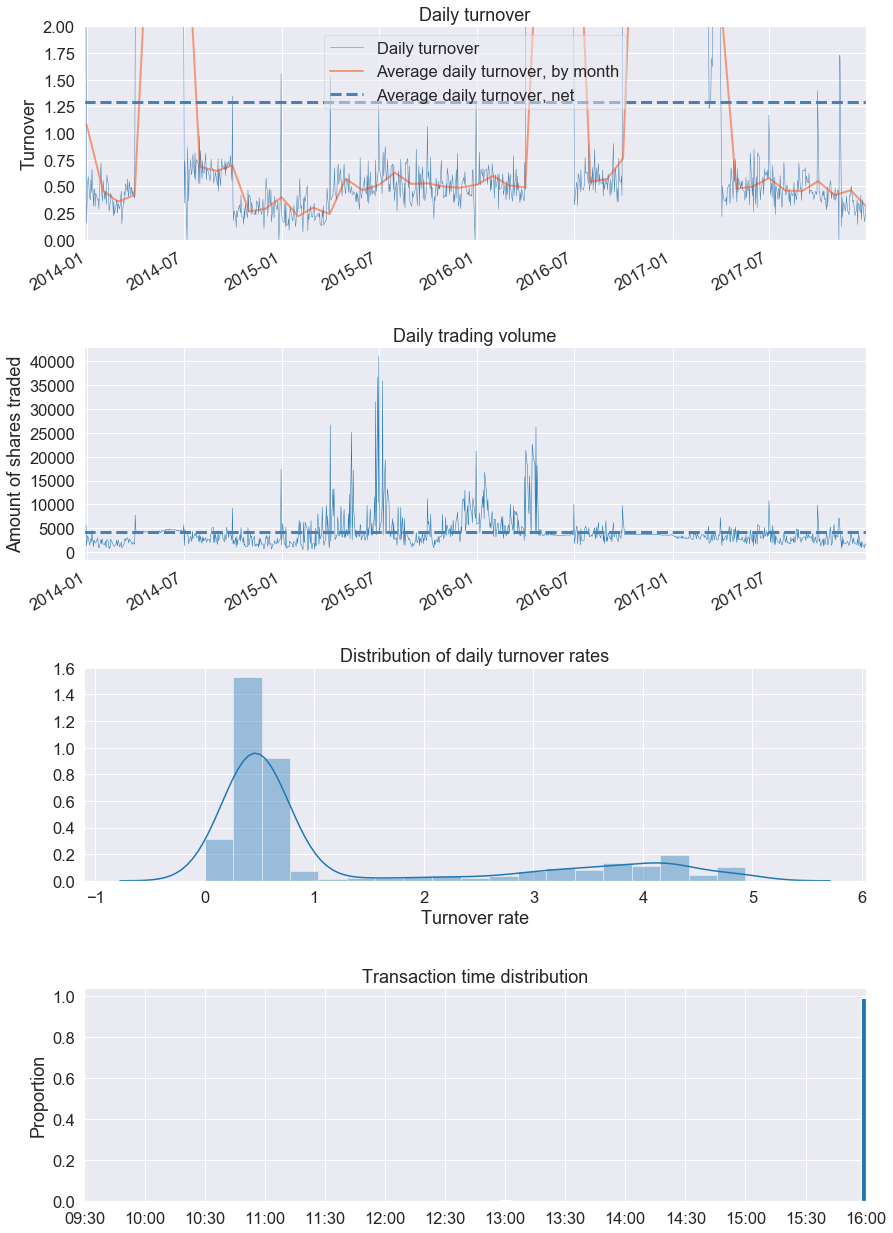

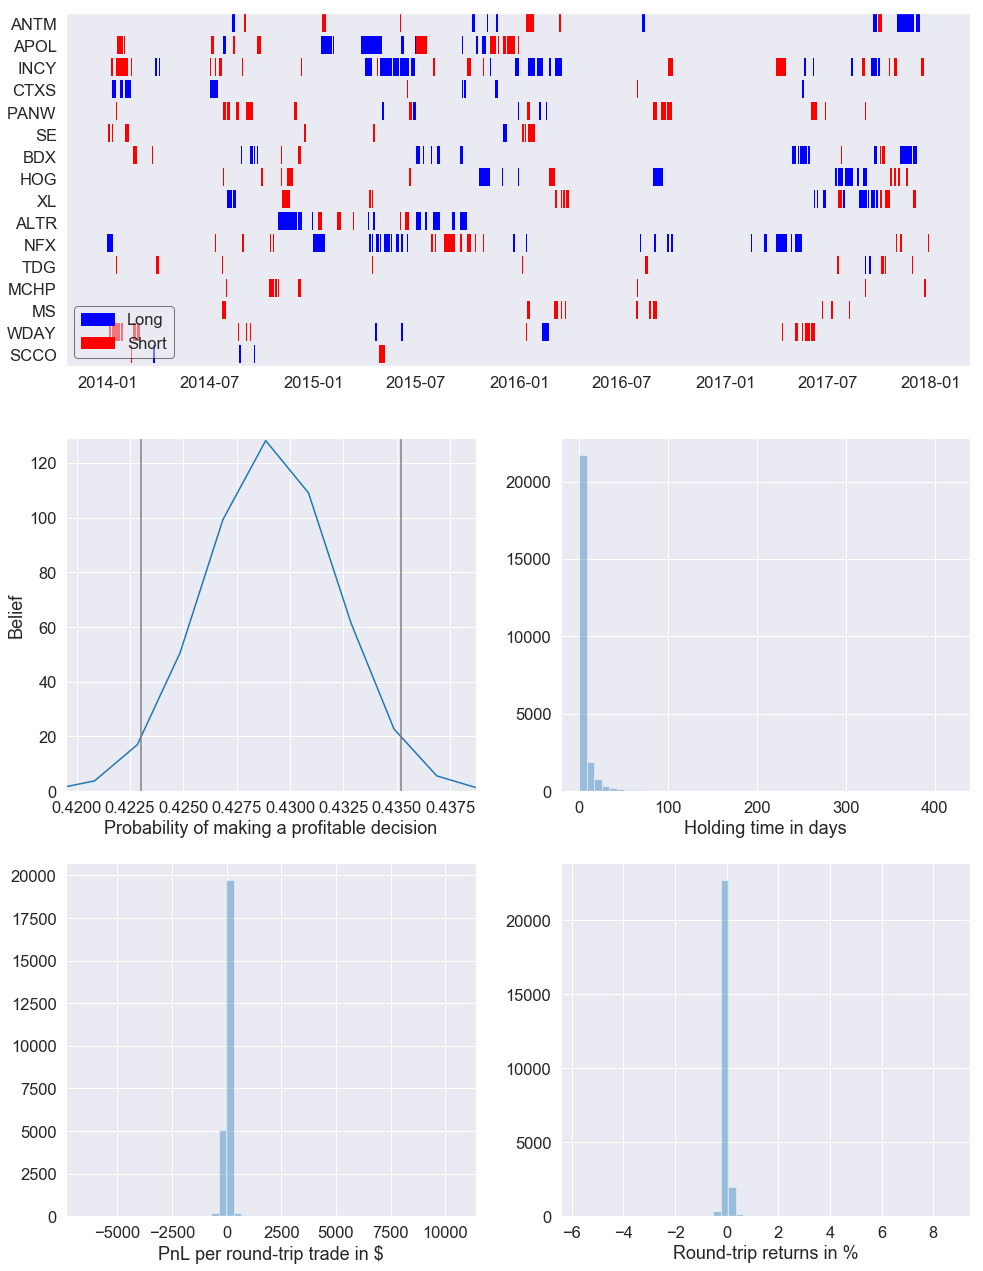

In [368]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
#                           live_start_date=LIVE_DATE, 
                          round_trips=True)